In [27]:
import numpy as np 
import os

os.chdir('/home/sarvagya/SEG-rc/')

file="results/metrics/seed-97-time-stitched/segSigma_1__segScale_3__guidanceScale_0/segAppliedLayers_(down_up)/blurRegions_(end)/up_block-1_concatenated.npy"
data = np.load(file)[:, 0, :, :, 1:]
data.shape

(10, 20, 1024, 7)

In [ ]:
import torch
from torch import Tensor

def compute_l2_difference(prev: Tensor, curr: Tensor) -> float:
    """
    Compute the L2 norm difference between two tensors.

    Args:
        prev (Tensor): The previous state tensor.
        curr (Tensor): The current state tensor.

    Returns:
        float: The Euclidean (L2) norm of (curr - prev) as a Python float.
    """
    return torch.norm(curr - prev).item()

# Example usage:
prev_state: Tensor = torch.randn(3, 1024 , 64)
curr_state: Tensor = prev_state + torch.randn(3, 1024 , 64) * 0.5  # simulate a small update
diff: float = compute_l2_difference(prev_state, curr_state)
print("L2 difference between states:", diff)


AttributeError: 'float' object has no attribute 'numpy'

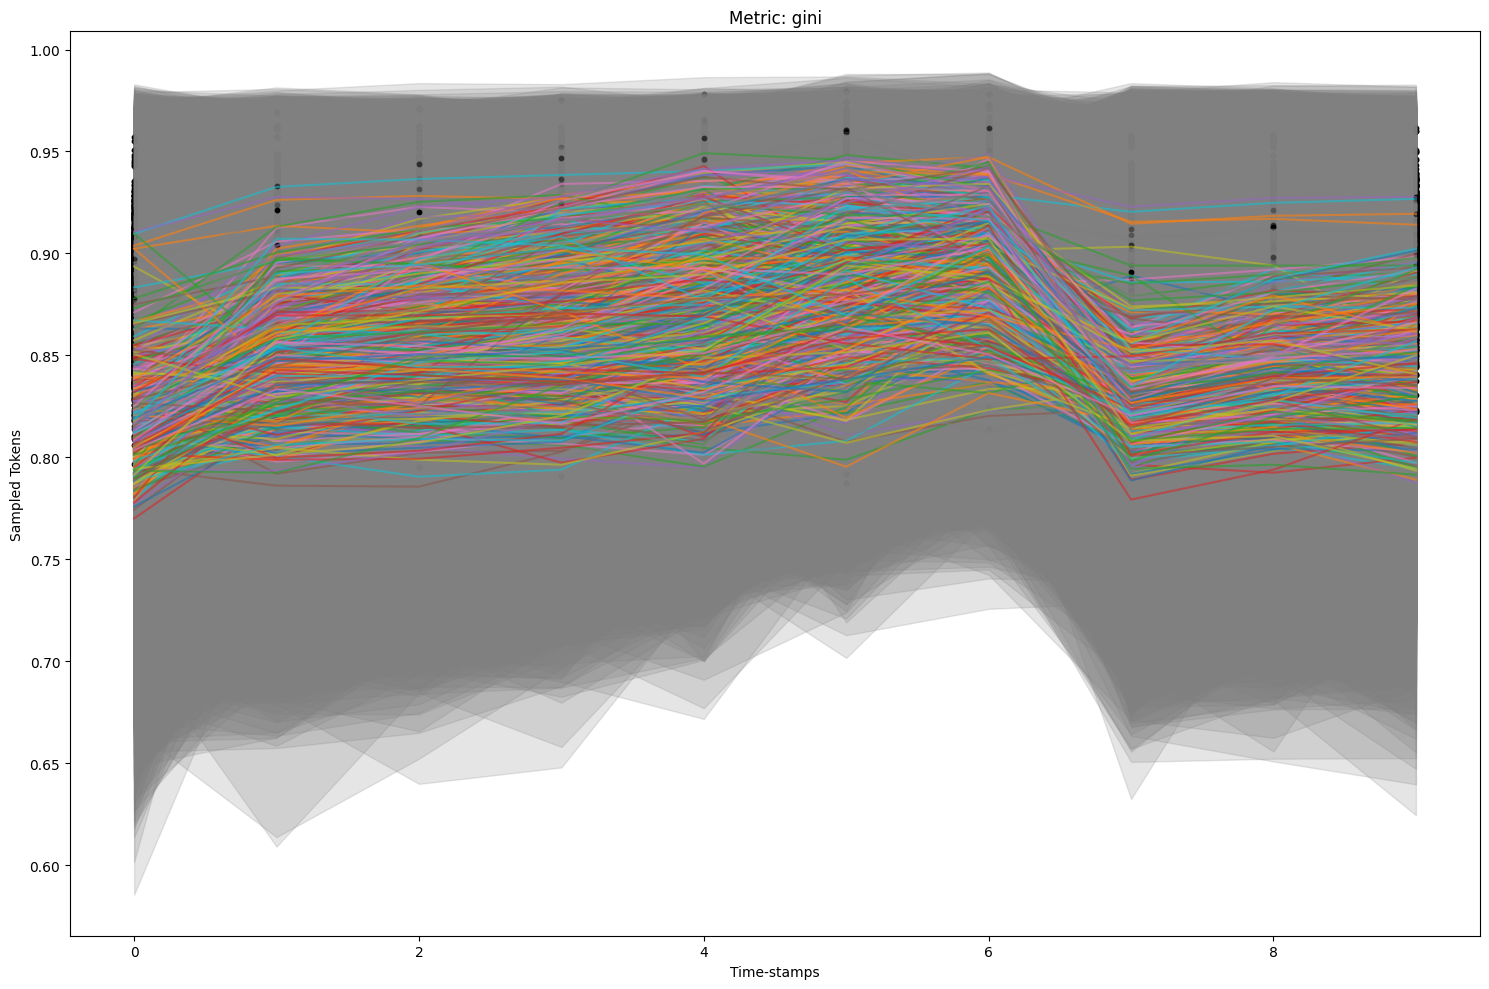

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_metrics(data, metric_idx=0, num_samples=1000):
    """
    Visualizes a single metric in a tensor with shape (time-stamps, attn_heads, tokens, metrics).
    
    Args:
        data (numpy.ndarray): Input tensor of shape (T, H, P, M) where:
                              T = time-stamps
                              H = attention heads
                              P = tokens
                              M = metrics (7)
        metric_idx (int): Index of the metric to visualize (default=0).
        num_samples (int): Number of token positions to sample for visualization (default=100).
    """
    T, H, P, M = data.shape  # Unpack dimensions
    metrics_name = ['gini', 'peak_avg', 'std_p', 'mean_p', 'lse', 'energy_ratio', 'grad_norm']
    if metric_idx >= M:
        raise ValueError(f"Invalid metric index {metric_idx}. Must be between 0 and {M-1}.")

    sampled_indices = np.random.choice(P, num_samples, replace=False)  # Randomly select tokens
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    metric_values = data[:, :, sampled_indices, metric_idx]  # Extract metric data
    metric_values = np.mean(metric_values, axis=1)  # Suppress attention heads (mean over H)
    
    # Compute percentiles (25th, median, 75th) along heads
    percentiles = np.percentile(data[:, :, sampled_indices, metric_idx], [25, 50, 75], axis=1)

    for i, sample in enumerate(sampled_indices):
        ax.plot(range(T), metric_values[:, i], label=f'Token {sample}', alpha=0.6)
        ax.fill_between(range(T), percentiles[0, :, i], percentiles[2, :, i], color='gray', alpha=0.2)
        ax.scatter(range(T), percentiles[1, :, i], marker='o', color='black', s=10)  # Median markers
    
    ax.set_title(f'Metric: {metrics_name[metric_idx]}')
    ax.set_xlabel('Time-stamps')
    ax.set_ylabel('Sampled Tokens')
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_metrics(data, metric_idx=0)  # Change metric index to visualize different metrics


In [34]:
# entropy, gini, peak_avg, std_p, mean_p, lse, energy_ratio, grad_norm
energy_tensor = data[:, 1, :, -3:-2]
# energy_tensor = np.transpose(energy_tensor, (0, 2, 1))
# energy_tensor = np.reshape(energy_tensor, (energy_tensor.shape[0], energy_tensor.shape[1],-1))
energy_tensor.shape

(10, 1024, 1)

In [32]:
print("Max:", np.max(energy_tensor), "Min:", np.min(energy_tensor))


Max: 30.67 Min: 11.56


In [27]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

def reduce_dim_sklearn(tensor: np.ndarray, target_dim: int = 30) -> np.ndarray:
    """
    Reduces the last dimension of the input tensor using Truncated SVD with normalization.

    Args:
        tensor (np.ndarray): Input tensor of shape (B, N, D), where D is the dimension to reduce.
        target_dim (int): The target dimension for reduction (default: 30).

    Returns:
        np.ndarray: Tensor with the last dimension reduced to target_dim.
    """
    if tensor.ndim != 3:
        raise ValueError("Input tensor must be 3D (batch, sequence, features).")

    B, N, D = tensor.shape  # Get original shape

    # Reshape to (B*N, D) for transformation
    reshaped_tensor = tensor.reshape(-1, D)

    # Apply StandardScaler to avoid overflow
    # scaler = StandardScaler()
    # reshaped_tensor = scaler.fit_transform(reshaped_tensor)

    # Apply Truncated SVD
    svd = TruncatedSVD(n_components=target_dim, random_state=42)
    reduced_tensor = svd.fit_transform(reshaped_tensor)

    # Reshape back to (B, N, target_dim)
    final_tensor = reduced_tensor.reshape(B, N, target_dim)

    return final_tensor

# Example usage
reduced_tensor = reduce_dim_sklearn(energy_tensor, target_dim=3)

print(reduced_tensor.shape)  # Output: (10, 1024, 30)


(10, 1024, 3)


/home/sarvagya/.cache/pypoetry/virtualenvs/seg-sdxl-mlrc-v70cfI2i-py3.10/lib/python3.10/site-packages/numpy/_core/_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


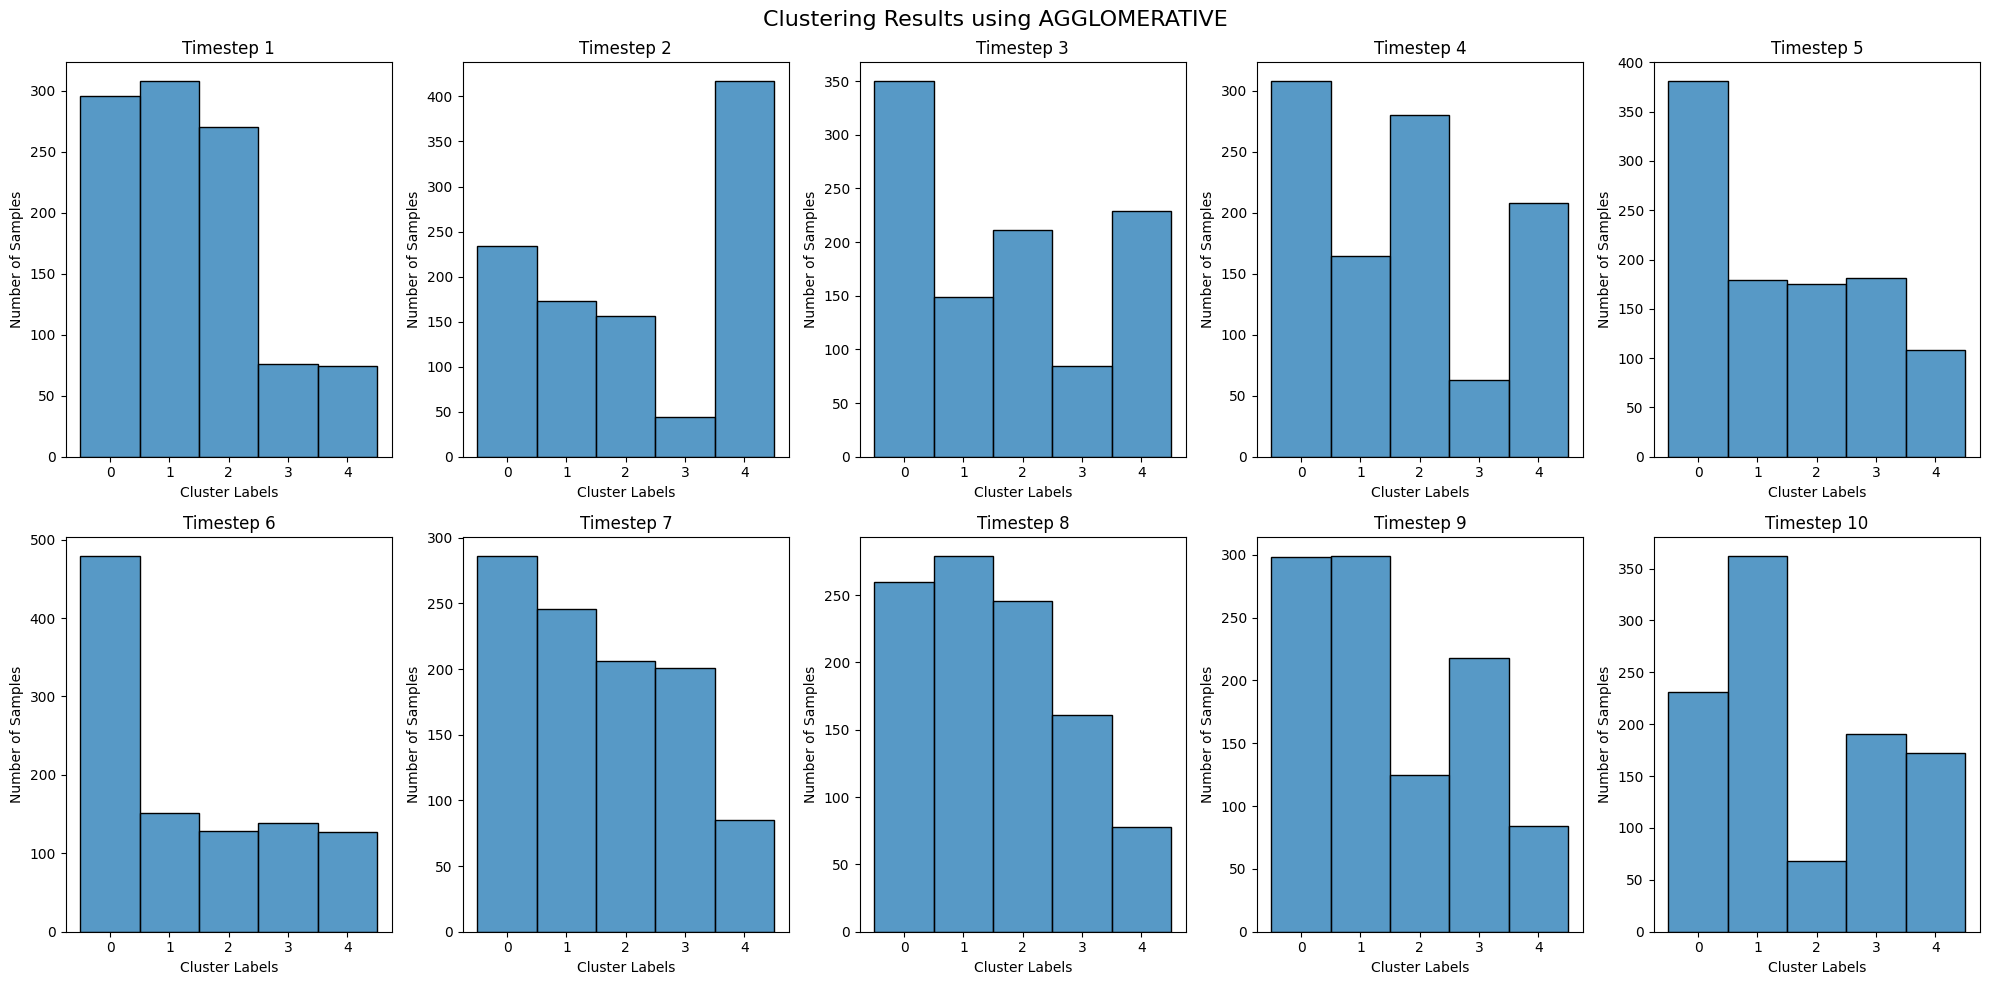

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import hdbscan

def perform_clustering(data, method="dbscan"):
    """
    Applies clustering on a single timestep (1024, 30) using the specified method.
    
    Args:
        data (np.ndarray): Shape (1024, 30), representing one timestep.
        method (str): Clustering method - "dbscan", "hdbscan", "kmeans", "agglomerative".

    Returns:
        np.ndarray: Cluster labels of shape (1024,)
    """
    if method == "dbscan":
        model = DBSCAN(eps=2.0, min_samples=10)
    elif method == "hdbscan":
        model = hdbscan.HDBSCAN(min_cluster_size=10)
    elif method == "kmeans":
        model = KMeans(n_clusters=5, random_state=42, n_init=10)
    elif method == "agglomerative":
        model = AgglomerativeClustering(n_clusters=5)
    else:
        raise ValueError("Invalid clustering method. Choose from ['dbscan', 'hdbscan', 'kmeans', 'agglomerative']")
    
    labels = model.fit_predict(data)
    return labels

def plot_clusters(tensor, method="dbscan"):
    """
    Performs clustering on each timestep and creates a subplot for each timestep.
    
    Args:
        tensor (np.ndarray): Shape (10, 1024, 30) - (timesteps, samples, features)
        method (str): Clustering method to use.
    """
    timesteps = tensor.shape[0]
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # 2 rows, 5 columns for 10 timesteps
    axes = axes.flatten()

    for t in range(timesteps):
        data = tensor[t]  # Shape: (1024, 30)
        labels = perform_clustering(data, method)

        # Plot clustering results in a histogram
        sns.histplot(labels, bins=np.arange(labels.max() + 2) - 0.5, kde=False, discrete=True, ax=axes[t])
        axes[t].set_xlabel("Cluster Labels")
        axes[t].set_ylabel("Number of Samples")
        axes[t].set_title(f"Timestep {t+1}")

    plt.suptitle(f"Clustering Results using {method.upper()}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage

# Try different clustering methods
for method in ["agglomerative"]:
    plot_clusters(reduced_tensor, method)


IndexError: index 1 is out of bounds for axis 1 with size 1

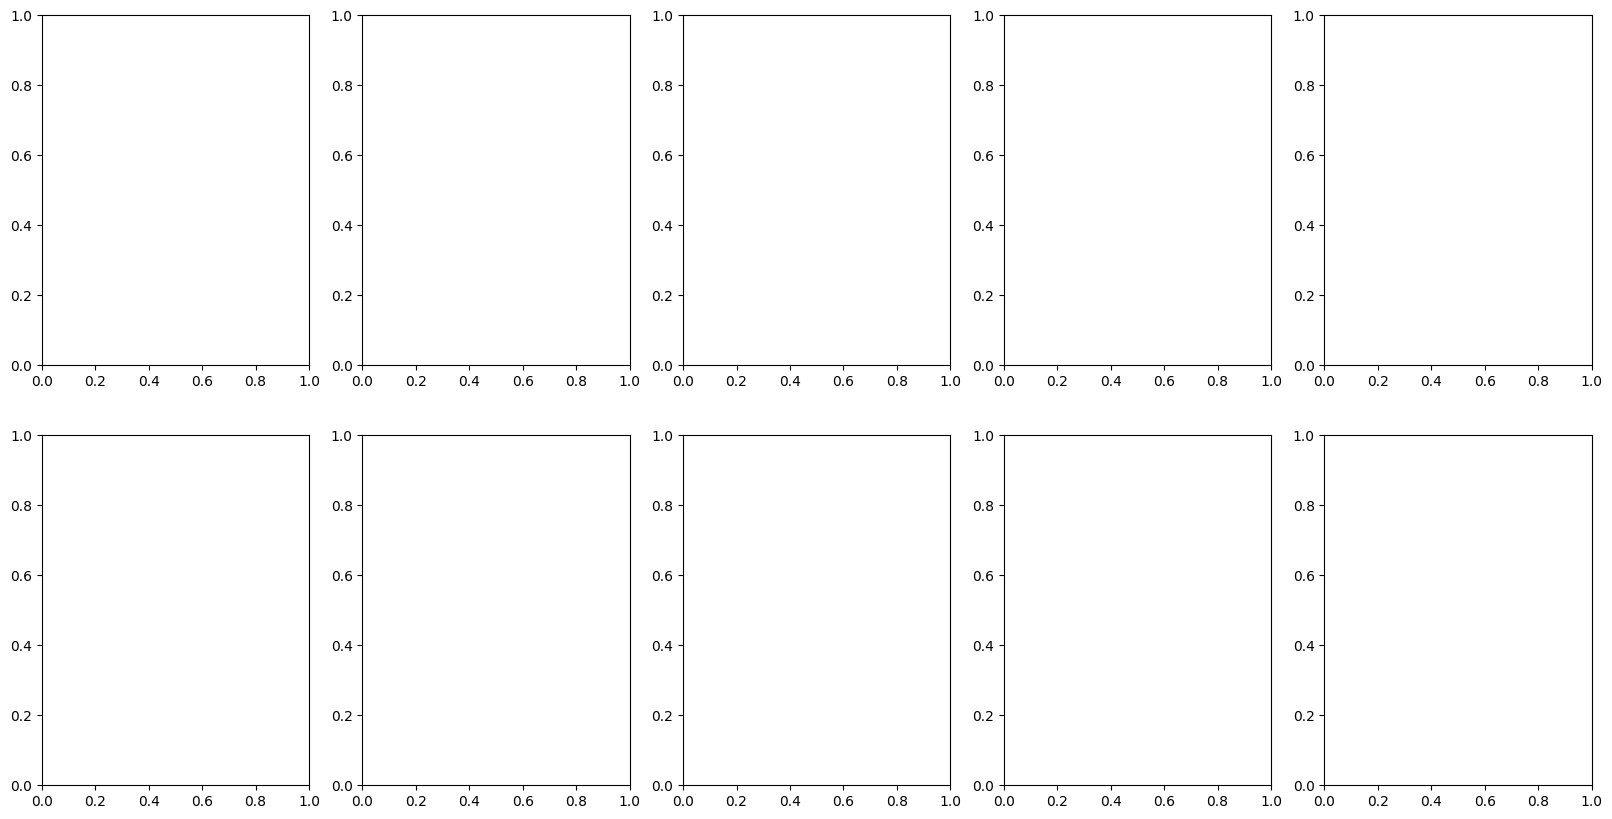

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import fcluster

def find_optimal_clusters(data, max_clusters=10):
    """
    Finds the optimal number of clusters using the silhouette score and dendrogram.

    Args:
        data (np.ndarray): Data to cluster (1024, 30)
        max_clusters (int): Maximum number of clusters to test.

    Returns:
        int: Optimal number of clusters.
    """
    best_n_clusters = 2
    best_silhouette = -1
    
    # Compute linkage matrix for dendrogram
    Z = linkage(data, method='ward')
    
    # Try different cluster numbers
    for k in range(2, max_clusters + 1):
        labels = fcluster(Z, k, criterion='maxclust')
        silhouette = silhouette_score(data, labels)
        
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_n_clusters = k

    return best_n_clusters

def perform_clustering(data, method="agglomerative", auto_n_clusters=True, max_clusters=10):
    """
    Performs hierarchical clustering with auto-tuned n_clusters.
    
    Args:
        data (np.ndarray): Shape (1024, 30), representing one timestep.
        method (str): Clustering method - "agglomerative".
        auto_n_clusters (bool): Whether to determine optimal n_clusters automatically.
        max_clusters (int): Maximum number of clusters to test.

    Returns:
        np.ndarray: Cluster labels of shape (1024,).
    """
    if auto_n_clusters:
        n_clusters = find_optimal_clusters(data, max_clusters)
    else:
        n_clusters = 5  # Default

    model = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage="ward",  # Try 'complete', 'average', 'single' for different behaviors
        metric="euclidean"  # Try 'manhattan', 'cosine' for different distance measures
    )
    
    labels = model.fit_predict(data)
    return labels, n_clusters

def plot_tsne_scatter(tensor, method="agglomerative", auto_n_clusters=True, max_clusters=10):
    """
    Applies t-SNE to visualize clusters in 2D space with auto-tuned clustering.
    
    Args:
        tensor (np.ndarray): Shape (10, 1024, 30) - (timesteps, samples, features)
        method (str): Clustering method to use.
        auto_n_clusters (bool): Whether to determine the optimal n_clusters automatically.
        max_clusters (int): Maximum number of clusters to test.
    """
    timesteps = tensor.shape[0]
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # 2 rows, 5 columns
    axes = axes.flatten()
    palette = sns.color_palette("tab10", max_clusters)  # Seaborn color palette

    for t in range(timesteps):
        data = tensor[t]  # Shape: (1024, 30)
        labels, optimal_clusters = perform_clustering(data, method, auto_n_clusters, max_clusters)

        # Apply t-SNE with PCA initialization for stability
        pca = PCA(n_components=1).fit_transform(data)  # Reduce to 10D before t-SNE
        tsne = TSNE(n_components=1, perplexity=30, init='pca', random_state=42)
        reduced_data = tsne.fit_transform(pca)  # Shape: (1024, 2)

        # Compute cluster evaluation metrics
        silhouette = silhouette_score(reduced_data, labels)
        davies_bouldin = davies_bouldin_score(reduced_data, labels)

        # Scatter plot with cluster labels
        scatter = axes[t].scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap="tab10", alpha=0.7)
        axes[t].set_title(f"Timestep {t+1} (Clusters: {optimal_clusters})\nSilhouette: {silhouette:.3f}, DB: {davies_bouldin:.3f}")
        axes[t].set_xlabel("t-SNE Component 1")
        axes[t].set_ylabel("t-SNE Component 2")

    plt.suptitle(f"t-SNE Visualization with Auto-Tuned Agglomerative Clustering", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
plot_tsne_scatter(energy_tensor, method="agglomerative", auto_n_clusters=True, max_clusters=20)


In [2]:
import torch
import torch.nn.functional as F
import time
import numpy as np
from tqdm import tqdm 
def gaussian_blur_2d(img, kernel_size, sigma):
    """
    Applies a 2D Gaussian blur to the input image.
    :param img: Input tensor of shape (C, H, W).
    :param kernel_size: Size of the Gaussian kernel.
    :param sigma: Standard deviation of the Gaussian kernel.
    :return: Blurred image tensor.
    """
    height = img.shape[-1]
    kernel_size = min(kernel_size, height - (height % 2 - 1))
    ksize_half = (kernel_size - 1) * 0.5
    # Create a 1D kernel
    x = torch.linspace(-ksize_half, ksize_half, steps=kernel_size, dtype=img.dtype, device=img.device)
    pdf = torch.exp(-0.5 * (x / sigma).pow(2))
    x_kernel = pdf / pdf.sum()
    # Create 2D kernel by outer product
    kernel2d = torch.mm(x_kernel[:, None], x_kernel[None, :])
    # Expand kernel to have shape (C, 1, k, k)
    kernel2d = kernel2d.expand(img.shape[-3], 1, kernel2d.shape[0], kernel2d.shape[1])
    padding = [kernel_size // 2] * 4
    img_padded = F.pad(img, padding, mode="reflect")
    return F.conv2d(img_padded, kernel2d, groups=img.shape[-3])

def ema_smoothing(query, alpha=0.9):
    """
    Applies exponential moving average (EMA) smoothing along the token dimension (index 2).
    :param query: Tensor of shape (batch, attn_heads, token_count, embed_dim).
    :param alpha: Smoothing factor (0 < alpha < 1).
    :return: Smoothed tensor of the same shape.
    """
    out = query.clone()
    # Apply EMA along the token_count dimension
    for t in range(1, query.shape[2]):
        out[:, :, t, :] = alpha * out[:, :, t - 1, :] + (1 - alpha) * out[:, :, t, :]
    return out

# Create a random tensor of shape (3, 20, 1024, 64) with dtype float64
query = torch.randn(3, 20, 1024, 64, dtype=torch.float64)

# Warm-up iterations (to avoid initialization overhead)
_ = gaussian_blur_2d(query, kernel_size=5, sigma=1.0)
_ = ema_smoothing(query, alpha=0.9)

num_iterations = 100
gaussian_times = []
ema_times = []

# Time the Gaussian blur method
for _ in tqdm(range(num_iterations), desc = "gaussian-2d"):
    start = time.time()
    _ = gaussian_blur_2d(query, kernel_size=5, sigma=1.0)
    end = time.time()
    gaussian_times.append(end - start)

# Time the EMA smoothing method
for _ in tqdm(range(num_iterations), desc="ema"):
    start = time.time()
    _ = ema_smoothing(query, alpha=0.9)
    end = time.time()
    ema_times.append(end - start)

gaussian_times = np.array(gaussian_times)
ema_times = np.array(ema_times)

print("Gaussian Blur: avg time = {:.6f}s, std = {:.6f}s".format(gaussian_times.mean(), gaussian_times.std()))
print("EMA Smoothing: avg time = {:.6f}s, std = {:.6f}s".format(ema_times.mean(), ema_times.std()))

# Compare memory usage (each output has the same shape and dtype)
result_gaussian = gaussian_blur_2d(query, kernel_size=5, sigma=1.0)
result_ema = ema_smoothing(query, alpha=0.9)

mem_gaussian = result_gaussian.element_size() * result_gaussian.nelement()
mem_ema = result_ema.element_size() * result_ema.nelement()

print("Memory usage (Gaussian Blur): {} bytes".format(mem_gaussian))
print("Memory usage (EMA Smoothing): {} bytes".format(mem_ema))


ema: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Gaussian Blur: avg time = 0.272535s, std = 0.036087s
EMA Smoothing: avg time = 0.065271s, std = 0.007462s
Memory usage (Gaussian Blur): 31457280 bytes
Memory usage (EMA Smoothing): 31457280 bytes


In [ ]:
import torch
import torch.nn.functional as F
import time
import numpy as np
from tqdm import tqdm

def compute_gaussian_kernel(kernel_size, sigma, device, dtype, C):
    """
    Precomputes a 2D Gaussian kernel.
    :param kernel_size: Size of the kernel.
    :param sigma: Standard deviation.
    :param device: Device for the tensor.
    :param dtype: Data type.
    :param C: Number of channels.
    :return: Kernel tensor of shape (C, 1, kernel_size, kernel_size).
    """
    ksize_half = (kernel_size - 1) * 0.5
    x = torch.linspace(-ksize_half, ksize_half, steps=kernel_size, dtype=dtype, device=device)
    pdf = torch.exp(-0.5 * (x / sigma).pow(2))
    x_kernel = pdf / pdf.sum()
    kernel2d = torch.mm(x_kernel[:, None], x_kernel[None, :])
    kernel2d = kernel2d.expand(C, 1, kernel2d.shape[0], kernel2d.shape[1])
    return kernel2d

def gaussian_blur_2d_with_kernel(img, kernel2d, kernel_size):
    """
    Applies 2D Gaussian blur using a precomputed kernel.
    :param img: Tensor of shape (C, H, W).
    :param kernel2d: Precomputed kernel tensor.
    :param kernel_size: Kernel size.
    :return: Blurred image tensor.
    """
    padding = [kernel_size // 2] * 4
    img_padded = F.pad(img, padding, mode="reflect")
    return F.conv2d(img_padded, kernel2d, groups=img.shape[-3])

def ema_smoothing(query, alpha=0.9):
    """
    Applies EMA smoothing along the token dimension (index 2).
    :param query: Tensor of shape (batch, attn_heads, token_count, embed_dim).
    :param alpha: EMA smoothing factor.
    :return: Smoothed tensor.
    """
    out = query.clone()
    for t in range(1, query.shape[2]):
        out[:, :, t, :] = alpha * out[:, :, t - 1, :] + (1 - alpha) * out[:, :, t, :]
    return out

# Create a random tensor of shape (3, 20, 1024, 64) with dtype float64.
# For Gaussian blur, we treat the tensor as (C, H, W) with C = batch (3).
query = torch.randn(3, 20, 1024, 64, dtype=torch.float64)
# For our Gaussian blur, we'll apply it on the first channel group (i.e. shape (C, H, W)).
# Here, C is taken as query.shape[-3] (i.e. 3)
C = query.shape[-3]
kernel_size = 5
sigma = 10.0

# Precompute the Gaussian kernel
kernel2d = compute_gaussian_kernel(kernel_size, sigma, device=query.device, dtype=query.dtype, C=C)

# Warm-up iterations
_ = gaussian_blur_2d_with_kernel(query, kernel2d, kernel_size)
_ = ema_smoothing(query, alpha=0.9)

num_iterations = 100
gaussian_times = []
ema_times = []

# Time the Gaussian blur with precomputed kernel method
for _ in tqdm(range(num_iterations), desc="Gaussian-Blur (precomputed)"):
    start = time.time()
    _ = gaussian_blur_2d_with_kernel(query, kernel2d, kernel_size)
    end = time.time()
    gaussian_times.append(end - start)

# Time the EMA smoothing method
for _ in tqdm(range(num_iterations), desc="EMA Smoothing"):
    start = time.time()
    _ = ema_smoothing(query, alpha=0.9)
    end = time.time()
    ema_times.append(end - start)

gaussian_times = np.array(gaussian_times)
ema_times = np.array(ema_times)

print("Gaussian Blur (precomputed): avg time = {:.6f}s, std = {:.6f}s".format(
    gaussian_times.mean(), gaussian_times.std()))
print("EMA Smoothing: avg time = {:.6f}s, std = {:.6f}s".format(
    ema_times.mean(), ema_times.std()))

# Compare memory usage (each output has the same shape and dtype)
result_gaussian = gaussian_blur_2d_with_kernel(query, kernel2d, kernel_size)
result_ema = ema_smoothing(query, alpha=0.9)

mem_gaussian = result_gaussian.element_size() * result_gaussian.nelement()
mem_ema = result_ema.element_size() * result_ema.nelement()

print("Memory usage (Gaussian Blur with precomputed kernel): {} bytes".format(mem_gaussian))
print("Memory usage (EMA Smoothing): {} bytes".format(mem_ema))


EMA Smoothing: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


Gaussian Blur (precomputed): avg time = 1.445267s, std = 0.226771s
EMA Smoothing: avg time = 0.263790s, std = 0.064971s
Memory usage (Gaussian Blur with precomputed kernel): 125829120 bytes
Memory usage (EMA Smoothing): 125829120 bytes


In [6]:
import torch
import torch.nn.functional as F
import time
import numpy as np

def ema_smoothing_vectorized(query, alpha=0.9):
    """
    Applies EMA smoothing along the token dimension (index 2) in a vectorized manner.
    For each sequence x[0:T] (with shape (T,)) the output is computed as:
      y_0 = x_0,
      y_t = alpha^t * x_0 + (1 - alpha) * sum_{i=1}^{t} alpha^{(t-i)} * x_i.
    This is done independently for every (batch, attn_head, embed_dim) slice.
    
    :param query: Tensor of shape (B, attn_heads, token_count, embed_dim)
    :param alpha: Smoothing factor (0 < alpha < 1)
    :return: Smoothed tensor of the same shape.
    """
    B, H, T, D = query.shape
    # Reshape to (B*H*D, T)
    x = query.permute(0, 1, 3, 2).reshape(-1, T)  # shape: (B*H*D, T)
    
    # Create the lower-triangular EMA matrix of shape (T, T)
    # Let indices i (row) and j (column): for i >= j:
    #   if j == 0: weight = alpha^i, else: weight = (1 - alpha) * alpha^(i - j)
    # For i < j, weight is 0.
    t_idx = torch.arange(T, device=x.device, dtype=x.dtype).unsqueeze(1)  # (T, 1)
    j_idx = torch.arange(T, device=x.device, dtype=x.dtype).unsqueeze(0)  # (1, T)
    # Create a mask for lower triangular (including diagonal)
    mask = (j_idx <= t_idx).to(x.dtype)
    # Compute the power difference
    power = t_idx - j_idx  # shape (T, T)
    
    # For the first column (j==0), we want alpha^(i) (which is alpha^(i-0))
    # For j>=1, we want (1 - alpha)*alpha^(i - j).
    kernel = torch.where(j_idx == 0, alpha ** t_idx, (1 - alpha) * (alpha ** power))
    # Zero out the upper triangular part (should already be zero due to mask)
    kernel = kernel * mask  # shape (T, T)
    
    # Apply the kernel: for each sequence x (shape (T,)), compute y = kernel @ x^T.
    # We can perform a batched matrix multiplication:
    # x is of shape (N, T) with N = B*H*D. We need to multiply each row by kernel.
    y = torch.matmul(x, kernel.t())  # kernel.t() has shape (T, T); y shape: (N, T)
    
    # Reshape back to (B, attn_heads, token_count, embed_dim)
    y = y.reshape(B, H, D, T).permute(0, 1, 3, 2)
    return y

# For comparison, here is the original loop-based EMA smoothing:
def ema_smoothing_loop(query, alpha=0.9):
    out = query.clone()
    for t in range(1, query.shape[2]):
        out[:, :, t, :] = alpha * out[:, :, t - 1, :] + (1 - alpha) * query[:, :, t, :]
    return out

# Create a random tensor of shape (3, 20, 1024, 64) with dtype float64
query = torch.randn(3, 20, 1024, 64, dtype=torch.float64)

# Warm-up iterations (to avoid initialization overhead)
_ = ema_smoothing_vectorized(query, alpha=0.9)
_ = ema_smoothing_loop(query, alpha=0.9)

num_iterations = 100
vectorized_times = []
loop_times = []

for _ in tqdm(range(num_iterations)):
    start = time.time()
    _ = ema_smoothing_vectorized(query, alpha=0.9)
    end = time.time()
    vectorized_times.append(end - start)

for _ in tqdm(range(num_iterations)):
    start = time.time()
    _ = ema_smoothing_loop(query, alpha=0.9)
    end = time.time()
    loop_times.append(end - start)

vectorized_times = np.array(vectorized_times)
loop_times = np.array(loop_times)

print("EMA Smoothing (vectorized): avg time = {:.6f}s, std = {:.6f}s".format(
    vectorized_times.mean(), vectorized_times.std()))
print("EMA Smoothing (loop): avg time = {:.6f}s, std = {:.6f}s".format(
    loop_times.mean(), loop_times.std()))

# Compare memory usage (both outputs have the same shape and dtype)
result_vectorized = ema_smoothing_vectorized(query, alpha=0.9)
result_loop = ema_smoothing_loop(query, alpha=0.9)
mem_vectorized = result_vectorized.element_size() * result_vectorized.nelement()
mem_loop = result_loop.element_size() * result_loop.nelement()
print("Memory usage (vectorized EMA): {} bytes".format(mem_vectorized))
print("Memory usage (loop EMA): {} bytes".format(mem_loop))


100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


EMA Smoothing (vectorized): avg time = 0.139366s, std = 0.010774s
EMA Smoothing (loop): avg time = 0.073627s, std = 0.006508s
Memory usage (vectorized EMA): 31457280 bytes
Memory usage (loop EMA): 31457280 bytes


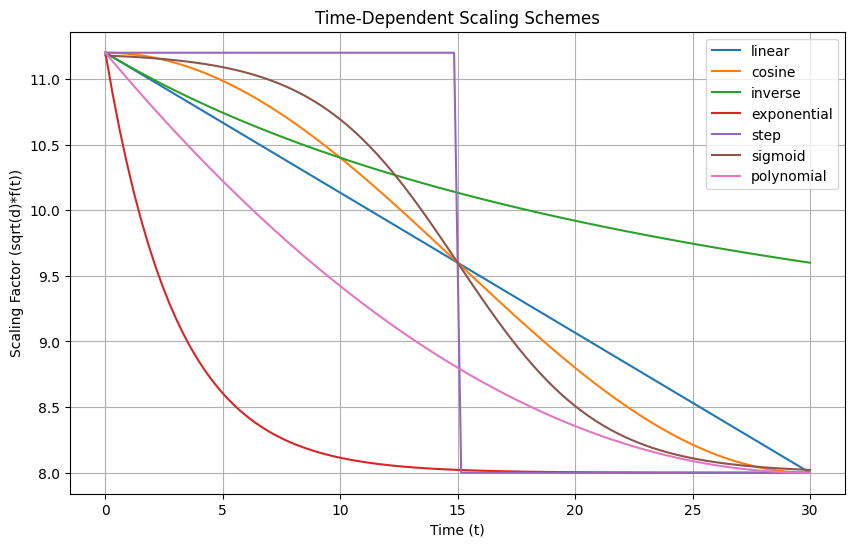

In [11]:
import math
from typing import Any, List

def time_dependent_scaling(
    t: float, 
    T: float, 
    d: float,
    scheme: str = "linear", 
    f0: float = 1.5, 
    **kwargs: Any
) -> float:
    """
    Computes a time-dependent scaling factor for softmax based on the current time stamp.
    The final scaling is: scale(t) = sqrt(d) * f(t), where f(t) anneals from f0 at t=0 to 1 at t=T.
    
    Supported schemes:
      - "linear": f(t) = 1 + (f0 - 1) * (1 - t/T)
      - "cosine": f(t) = 1 + (f0 - 1) * 0.5 * (1 + cos(pi * t / T))
      - "inverse": f(t) = 1 + (f0 - 1) / (1 + t/T)
      - "exponential": f(t) = 1 + (f0 - 1) * exp(-lambda_ * t / T) (default lambda_=5)
      - "step": f(t) = f0 if t < T/2 else 1.0
      - "sigmoid": f(t) = 1 + (f0 - 1) / (1 + exp(k * (t/T - 0.5))) (default k=10)
      - "polynomial": f(t) = 1 + (f0 - 1) * ((T - t)/T)^p (default p=2)
    
    :param t: Current time step (must be in [0, T]).
    :param T: Total time steps.
    :param d: Dimension size (e.g., embedding dimension).
    :param scheme: Scheduling scheme name.
    :param f0: Initial multiplier at t=0 (typically > 1).
    :param kwargs: Additional parameters for specific schemes.
        For "exponential": lambda_ (float), default is 5.
        For "sigmoid": k (float), default is 10.
        For "polynomial": p (float), default is 2.
    :return: The overall scaling factor (float).
    """
    # Clamp t between 0 and T
    t = max(0.0, min(t, T))
    
    if scheme == "linear":
        f_t = 1 + (f0 - 1) * (1 - t / T)
    elif scheme == "cosine":
        f_t = 1 + (f0 - 1) * 0.5 * (1 + math.cos(math.pi * t / T))
    elif scheme == "inverse":
        f_t = 1 + (f0 - 1) / (1 + t / T)
    elif scheme == "exponential":
        lambda_ = kwargs.get("lambda_", 10)
        f_t = 1 + (f0 - 1) * math.exp(-lambda_ * t / T)
    elif scheme == "step":
        f_t = f0 if t < T / 2 else 1.0
    elif scheme == "sigmoid":
        k = kwargs.get("k", 10.0)
        f_t = 1 + (f0 - 1) / (1 + math.exp(k * (t / T - 0.5)))
    elif scheme == "polynomial":
        p = kwargs.get("p", 2.0)
        f_t = 1 + (f0 - 1) * ((T - t) / T) ** p
    else:
        raise ValueError(f"Unknown scheme: {scheme}")
        
    return math.sqrt(d) * f_t

def visualize_scaling_schemes(
    T: float,
    d: float,
    schemes: List[str],
    f0: float = 1.5,
    num_points: int = 100,
    **kwargs: Any
) -> None:
    """
    Visualizes the scaling factor curves for different scheduling schemes over time.
    
    :param T: Total time steps.
    :param d: Dimension size.
    :param schemes: List of scheduling scheme names to visualize.
    :param f0: Initial multiplier at t=0.
    :param num_points: Number of points in the time grid.
    :param kwargs: Additional keyword arguments passed to time_dependent_scaling.
    """
    import matplotlib.pyplot as plt  # in case not already imported
    ts = [T * i / (num_points - 1) for i in range(num_points)]
    
    plt.figure(figsize=(10, 6))
    
    for scheme in schemes:
        scaling_factors = [time_dependent_scaling(t, T, d, scheme, f0, **kwargs) for t in ts]
        plt.plot(ts, scaling_factors, label=f"{scheme}")
    
    plt.xlabel("Time (t)")
    plt.ylabel("Scaling Factor (sqrt(d)*f(t))")
    plt.title("Time-Dependent Scaling Schemes")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
if __name__ == "__main__":
    T_total = 30  # total time steps
    d = 64          # e.g., embedding dimension
    schemes_to_plot = ["linear", "cosine", "inverse", "exponential", "step", "sigmoid", "polynomial"]
    
    visualize_scaling_schemes(T_total, d, schemes_to_plot, f0=1.4)


In [3]:
import torch
import torch.nn.functional as F
import time
import numpy as np
from tqdm import tqdm
from functools import lru_cache
from typing import Tuple

# -------------------------------
# Gaussian Blur Functions with LRU caching
# -------------------------------

@lru_cache(maxsize=128)
def get_gaussian_kernel_cached(
    kernel_size: int, 
    sigma: float, 
    C: int, 
    device_str: str, 
    dtype_str: str
) -> torch.Tensor:
    """
    Computes and caches a 2D Gaussian kernel.
    
    :param kernel_size: Size of the kernel (assumed odd).
    :param sigma: Standard deviation.
    :param C: Number of channels.
    :param device_str: Device as a string (e.g., "cpu" or "cuda:0").
    :param dtype_str: Data type as a string (e.g., "float32" or "float64").
    :return: Kernel tensor of shape (C, 1, kernel_size, kernel_size).
    """
    device = torch.device(device_str)
    dtype = getattr(torch, dtype_str)
    
    ksize_half = (kernel_size - 1) * 0.5
    x = torch.linspace(-ksize_half, ksize_half, steps=kernel_size, device=device, dtype=dtype)
    pdf = torch.exp(-0.5 * (x / sigma).pow(2))
    x_kernel = pdf / pdf.sum()
    # Outer product to form a 2D kernel.
    kernel2d = torch.mm(x_kernel[:, None], x_kernel[None, :])
    # Expand kernel for each channel: shape becomes (C, 1, kernel_size, kernel_size)
    kernel2d = kernel2d.expand(C, 1, kernel_size, kernel_size)
    return kernel2d

def get_gaussian_kernel_2d(
    kernel_size: int, 
    sigma: float, 
    C: int, 
    device: torch.device, 
    dtype: torch.dtype
) -> torch.Tensor:
    """
    Wrapper that converts device and dtype to strings and calls the cached function.
    """
    return get_gaussian_kernel_cached(
        kernel_size, sigma, C, str(device), str(dtype).split('.')[-1]
    )

def gaussian_blur_2d_with_kernel(img: torch.Tensor, kernel2d: torch.Tensor, kernel_size: int) -> torch.Tensor:
    """
    Applies 2D Gaussian blur using a precomputed kernel.
    
    :param img: Tensor of shape (C, H, W).
    :param kernel2d: Precomputed kernel tensor.
    :param kernel_size: Kernel size.
    :return: Blurred image tensor.
    """
    padding = [kernel_size // 2] * 4
    img_padded = F.pad(img, padding, mode="reflect")
    return F.conv2d(img_padded, kernel2d, groups=img.shape[-3])

def gaussian_blur_2d(img: torch.Tensor, kernel_size: int, sigma: float) -> torch.Tensor:
    """
    Applies a 2D Gaussian blur to the input image.
    
    :param img: Tensor of shape (C, H, W).
    :param kernel_size: Size of the Gaussian kernel.
    :param sigma: Standard deviation.
    :return: Blurred image tensor.
    """
    height = img.shape[-1]
    kernel_size = min(kernel_size, height - (height % 2 - 1))
    C = img.shape[-3]
    kernel2d = get_gaussian_kernel_2d(kernel_size, sigma, C, img.device, img.dtype)
    return gaussian_blur_2d_with_kernel(img, kernel2d, kernel_size)

# -------------------------------
# Bidirectional EMA Smoothing (TorchScript Compiled)
# -------------------------------

@torch.jit.script
def bidirectional_ema_smoothing_script(query: torch.Tensor, alpha: float) -> torch.Tensor:
    # query has shape (batch, attn_heads, token_count, embed_dim)
    B, H, T, D = query.shape
    out_fwd = query.clone()
    out_bwd = query.clone()
    # Forward EMA: iterate from t=1 to T-1.
    for t in range(1, T):
        out_fwd[:, :, t, :] = alpha * out_fwd[:, :, t - 1, :] + (1 - alpha) * query[:, :, t, :]
    # Backward EMA: iterate from t=T-2 down to 0.
    for t in range(T - 2, -1, -1):
        out_bwd[:, :, t, :] = alpha * out_bwd[:, :, t + 1, :] + (1 - alpha) * query[:, :, t, :]
    return (out_fwd + out_bwd) / 2

def bidirectional_ema_smoothing(query: torch.Tensor, alpha: float = 0.9) -> torch.Tensor:
    """
    Applies bidirectional EMA smoothing along the token dimension (index 2).
    
    For each sequence (each combination of batch, attn_head, and embed_dim),
    two EMA passes are computed:
      - Forward pass (top-down): y_fwd[t] = alpha * y_fwd[t-1] + (1 - alpha) * x[t], with y_fwd[0] = x[0].
      - Backward pass (bottom-up): y_bwd[t] = alpha * y_bwd[t+1] + (1 - alpha) * x[t], with y_bwd[T-1] = x[T-1].
    
    The final smoothed output is the average of the forward and backward passes.
    
    This function is compiled with TorchScript to optimize the looping.
    
    :param query: Input tensor of shape (batch, attn_heads, token_count, embed_dim).
    :param alpha: EMA smoothing factor.
    :return: Smoothed tensor of the same shape.
    """
    return bidirectional_ema_smoothing_script(query, alpha)

# -------------------------------
# Comparison and Testing
# -------------------------------

if __name__ == "__main__":
    # Create a random tensor of shape (3, 20, 1024, 64) with dtype float64.
    query = torch.randn(3, 20, 1024, 64, dtype=torch.float64)
    
    # For Gaussian blur, we treat the tensor as an image.
    # We merge the batch and attn_heads dimensions: shape becomes (3*20, 1024, 64)
    query_img = query.view(query.shape[0] * query.shape[1], query.shape[2], query.shape[3])
    
    kernel_size = 5
    sigma = 10.0
    
    # Warm-up iterations
    _ = gaussian_blur_2d(query_img, kernel_size, sigma)
    _ = bidirectional_ema_smoothing(query, alpha=0.9)
    
    num_iterations = 100
    gaussian_times = []
    ema_times = []
    
    # Time Gaussian blur with precomputed kernel on the reshaped tensor.
    for _ in tqdm(range(num_iterations), desc="Gaussian-Blur (precomputed)"):
        start = time.time()
        _ = gaussian_blur_2d(query_img, kernel_size, sigma)
        end = time.time()
        gaussian_times.append(end - start)
    
    # Time bidirectional EMA smoothing.
    for _ in tqdm(range(num_iterations), desc="Bidirectional EMA Smoothing"):
        start = time.time()
        _ = bidirectional_ema_smoothing(query, alpha=0.9)
        end = time.time()
        ema_times.append(end - start)
    
    gaussian_times = np.array(gaussian_times)
    ema_times = np.array(ema_times)
    
    print("Gaussian Blur (precomputed): avg time = {:.6f}s, std = {:.6f}s".format(
        gaussian_times.mean(), gaussian_times.std()))
    print("Bidirectional EMA Smoothing: avg time = {:.6f}s, std = {:.6f}s".format(
        ema_times.mean(), ema_times.std()))
    
    # Compare memory usage (both outputs have the same number of elements)
    result_gaussian = gaussian_blur_2d(query_img, kernel_size, sigma)
    result_ema = bidirectional_ema_smoothing(query, alpha=0.9)
    
    mem_gaussian = result_gaussian.element_size() * result_gaussian.nelement()
    mem_ema = result_ema.element_size() * result_ema.nelement()
    
    print("Memory usage (Gaussian Blur with precomputed kernel): {} bytes".format(mem_gaussian))
    print("Memory usage (Bidirectional EMA Smoothing): {} bytes".format(mem_ema))


Bidirectional EMA Smoothing: 100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Gaussian Blur (precomputed): avg time = 0.231870s, std = 0.134795s
Bidirectional EMA Smoothing: avg time = 0.120015s, std = 0.181505s
Memory usage (Gaussian Blur with precomputed kernel): 31457280 bytes
Memory usage (Bidirectional EMA Smoothing): 31457280 bytes
